# Setup

**Imports**

In [50]:
import contextily as cx
import datetime as dt
import geopandas
import IPython
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ruptures as rpt
import seaborn as sns

from collections import Counter, defaultdict
from loadmydata.load_molene_meteo import load_molene_meteo_dataset
from math import log
from pygsp import graphs
from scipy.linalg import eig
from scipy.spatial.distance import pdist, squareform
from scipy.signal import spectrogram

rng = np.random.default_rng()

# Question 1

The following cell loads the training data set `X_train` and `y_train`.
`X_train` is a list of 100 signals; `y_train` is a list of 100 symbol sequences. 

The signals have a varying number of symbols with a varying duration. 
There is a brief silence between each symbol.
The sampling frequency is $22.05 $ kHz.

In [51]:
FS = 22050  # sampling frequency (Hz)

X_train = np.load("X_train.npy", allow_pickle=True).tolist()
y_train = np.load("y_train.npy", allow_pickle=True).tolist()

In [52]:
signal, symbols = X_train[2], y_train[2]
print(" ".join(symbols))
IPython.display.Audio(signal, rate=FS)

D 6 A 8 3 D 1 8 B 9


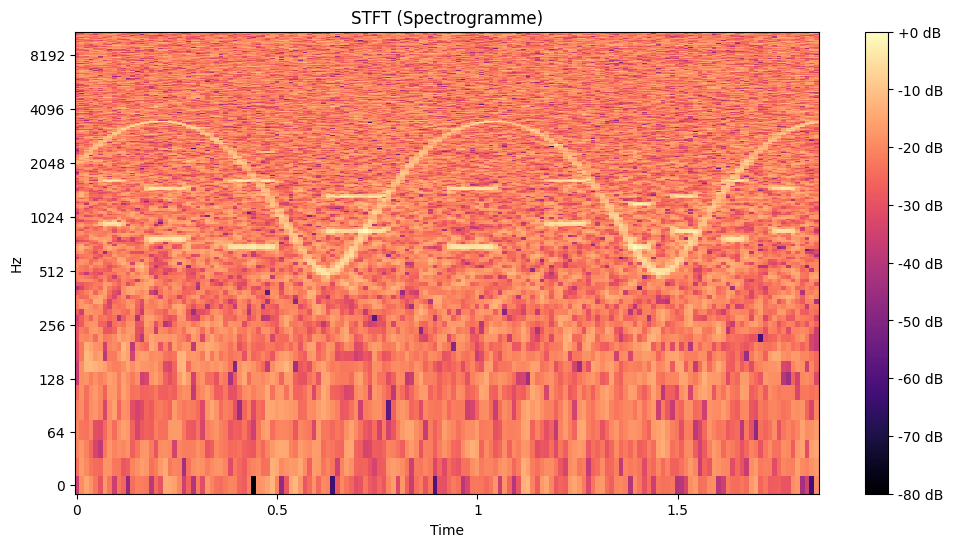

In [53]:
# Paramètres STFT
n_fft = 1024  # Longueur de la fenêtre FFT
hop_length = 256  # Nombre d'échantillons entre les trames successives

# Effectuer STFT
stft = librosa.stft(signal, n_fft=n_fft, hop_length=hop_length)

# Convertir en dB
stft_db = librosa.amplitude_to_db(np.abs(stft), ref=np.max)

# Tracer le spectrogramme
plt.figure(figsize=(12, 6))
librosa.display.specshow(stft_db, sr=FS, hop_length=hop_length, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('STFT (Spectrogramme)')
plt.show()


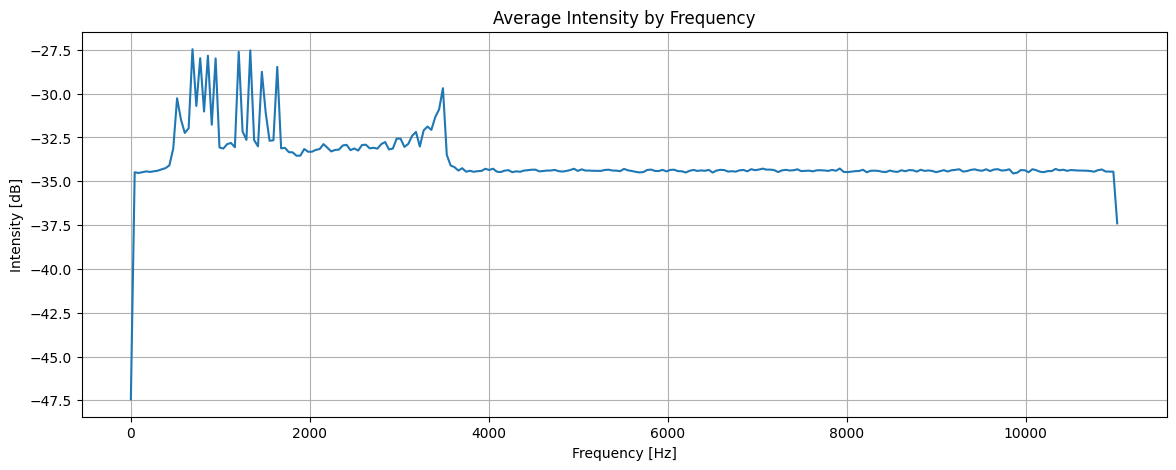

In [54]:
accumulated_spectra = np.zeros(int(512 / 2 + 1))  # +1 for the Nyquist frequency

for signal in X_train:

    frequencies, times, Sxx = spectrogram(signal, FS, nperseg=512)
    accumulated_spectra += np.mean(Sxx, axis=1)

average_spectra = accumulated_spectra / len(X_train)

# Plot the average intensity by frequency
plt.figure(figsize=(14, 5))
plt.plot(frequencies, 10 * np.log10(average_spectra))
plt.title('Average Intensity by Frequency')
plt.ylabel('Intensity [dB]')
plt.xlabel('Frequency [Hz]')
plt.grid(True)
plt.show()

In [55]:
# Find the indices of the 8 highest values
top_indices = np.argsort(average_spectra)[-8:]
top_frequencies = frequencies[top_indices]
top_powers = average_spectra[top_indices]

In [56]:
np.sort(top_frequencies)

array([ 689.0625    ,  775.1953125 ,  861.328125  ,  947.4609375 ,
       1205.859375  , 1335.05859375, 1464.2578125 , 1636.5234375 ])

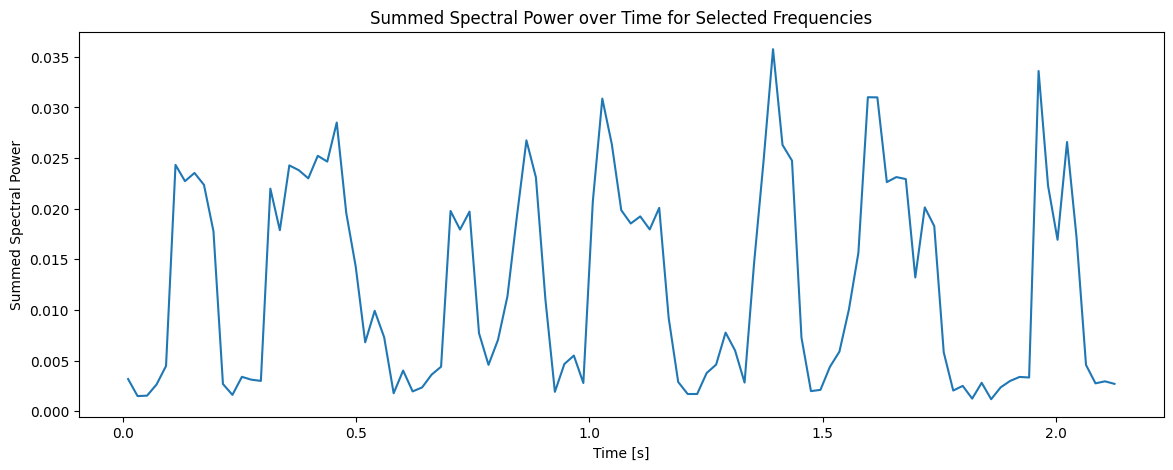

In [57]:
def spectral_power_around_8_frequencies(signal, f_interval = 5):
    # Compute the spectrogram for the chosen signal
    frequencies, times, Sxx = spectrogram(signal, FS, nperseg=512)

    # Initialize the array to hold the summed spectral power for the top frequencies
    summed_power = np.zeros_like(times)

    # For each top frequency, find the nearest indices within the interval and sum the spectral power
    for top_freq in top_frequencies:
        freq_indices = np.where((frequencies >= top_freq - f_interval) & 
                                (frequencies <= top_freq + f_interval))[0]
        summed_power += np.sum(Sxx[freq_indices, :], axis=0)
        
    return times, summed_power, Sxx
        
times, summed_power, _ = spectral_power_around_8_frequencies(signal, f_interval = 5)

# Plot the summed spectral power over time
plt.figure(figsize=(14, 5))
plt.plot(times, summed_power)
plt.title('Summed Spectral Power over Time for Selected Frequencies')
plt.xlabel('Time [s]')
plt.ylabel('Summed Spectral Power')
plt.show()

In [58]:
def detect_intervals_above_threshold(summed_power, threshold):

    intervals = []
    start = None

    # Iterate over the summed power array
    for i, power in enumerate(summed_power):
        if power > threshold and start is None:
            start = i
        elif power <= threshold and start is not None:
            intervals.append((start, i))
            start = None

    if start is not None:
        intervals.append((start, len(summed_power)))

    return intervals


def assign_interval_to_signal(signal, symbols, f_interval = 5, treshold = 0.014, window_size = 2):
    
    dico_sign = {symbol: [] for symbol in symbols}  
    
    _, summed_power, Sxx = spectral_power_around_8_frequencies(signal)
    
    ### ON LISSE LE SIGNAL 1D pour atténuer le bruit
    if window_size > 0 :
        window = np.ones(int(window_size)) / float(window_size)
        summed_power= np.convolve(summed_power, window, 'valid')
    
    intervals = detect_intervals_above_threshold(summed_power, treshold)

    # Pour chaque interval, on trouve le top 2 des fréquences dominantes
    top_freqs_per_interval = []
    for (start, end) in intervals:
        mean_power = np.mean(Sxx[:, start:end], axis=1)
        top_indices = np.argsort(mean_power)[-2:]
        top_freqs = frequencies[top_indices]
        top_freqs_per_interval.append(top_freqs)

   # Match des intervalles et des symboles
    for i, top_freqs in enumerate(top_freqs_per_interval):
        symbol = symbols[i]
        dico_sign[symbol].append(np.sort(top_freqs))
        
    return dico_sign

In [59]:
assign_interval_to_signal(signal, symbols, f_interval = 5, treshold = 0.014, window_size = 2)

{'D': [array([ 861.328125, 1205.859375]), array([ 947.4609375, 1205.859375 ])],
 '6': [array([ 775.1953125 , 1335.05859375])],
 'A': [array([732.12890625, 861.328125  ])],
 '8': [array([ 861.328125, 1205.859375]), array([ 947.4609375, 1636.5234375])],
 '3': [array([ 775.1953125, 1205.859375 ])],
 '1': [array([ 861.328125 , 1464.2578125])],
 'B': [],
 '9': []}

In [60]:
matches = []
discrepancies = []

for i, (signal, num_symbols) in enumerate(zip(X_train, y_train)):
       
    match = assign_interval_to_signal(signal, num_symbols, f_interval = 5, treshold = 0.014, window_size = 2)
    nb_val = 0
    for v in match.values():
        nb_val += len(v)

    if nb_val == len(num_symbols):
        matches.append(i)
    else :
        discrepancies.append(i)

print(f"Number of matches: {len(matches)}")
print(f"Number of discrepancies: {len(discrepancies)}")

Number of matches: 100
Number of discrepancies: 0


In [61]:
# Process each signal in the training set
all_symbols_dict = defaultdict(list)

for signal, symbols in zip(X_train, y_train):

    dico_sign = assign_interval_to_signal(signal, symbols)

    for symbol, freq_intervals in dico_sign.items():
        all_symbols_dict[symbol].extend(freq_intervals)

# Find the most common frequency interval for each symbol
most_common_freqs = {}

for symbol, freq_intervals in all_symbols_dict.items():

    freq_intervals_tuples = [tuple(freq_interval) for freq_interval in freq_intervals]
    most_common_freq = max(set(freq_intervals_tuples), key=freq_intervals_tuples.count)
    most_common_freqs[symbol] = np.array(most_common_freq)

table_assos = most_common_freqs
table_assos

{'5': array([ 775.1953125 , 1335.05859375]),
 'C': array([ 861.328125 , 1636.5234375]),
 '3': array([ 689.0625   , 1464.2578125]),
 '8': array([ 861.328125  , 1335.05859375]),
 '7': array([ 861.328125, 1205.859375]),
 'B': array([ 775.1953125, 1636.5234375]),
 'A': array([ 689.0625   , 1636.5234375]),
 'D': array([ 947.4609375, 1636.5234375]),
 '6': array([ 775.1953125, 1464.2578125]),
 '1': array([ 689.0625  , 1205.859375]),
 '9': array([ 861.328125 , 1464.2578125]),
 '*': array([ 947.4609375, 1205.859375 ]),
 '#': array([ 947.4609375, 1464.2578125]),
 '4': array([ 775.1953125, 1205.859375 ]),
 '2': array([ 689.0625    , 1335.05859375]),
 '0': array([ 947.4609375 , 1335.05859375])}

In [62]:
correct_predictions = 0
total_predictions = 0

for i, (signal, num_symbols) in enumerate(zip(X_train, y_train)):
    predicted_intervals = assign_interval_to_signal(signal, num_symbols)
    
    for symbol, predicted_freqs in predicted_intervals.items():
        predicted_freqs_tuples = [tuple(freqs) for freqs in predicted_freqs]
        
        for freq_tuple in predicted_freqs_tuples:
            total_predictions += 1
            
            # On vérifie si la prédiction est correcte
            if freq_tuple in table_assos.get(symbol, []):
                correct_predictions += 1

accuracy = (correct_predictions / total_predictions) * 100 if total_predictions > 0 else 0
print(f"Accuracy: {accuracy}%")

Accuracy: 98.87482419127988%


# Question 2

In [63]:
X_test = np.load("X_test.npy", allow_pickle=True).tolist()

In [64]:
def find_symbols_for_frequencies(symbol_dict, freq_list):

    freq_to_symbol = {tuple(value): key for key, value in symbol_dict.items()}
    
    symbols = [freq_to_symbol.get(tuple(sorted(freq_array)), None) for freq_array in freq_list]
    
    return symbols

def associe_signal_to_symbols(signal, table_assos, f_interval = 5, treshold = 0.014, window_size = 2):
        
    # Compute the spectrogram for the chosen signal
    frequencies, times, Sxx = spectrogram(signal, FS, nperseg=512)

    # Initialize the array to hold the summed spectral power for the top frequencies
    summed_power = np.zeros_like(times)

    # For each top frequency, find the nearest indices within the interval and sum the spectral power
    for top_freq in top_frequencies:
        freq_indices = np.where((frequencies >= top_freq - f_interval) & 
                                (frequencies <= top_freq + f_interval))[0]
        summed_power += np.sum(Sxx[freq_indices, :], axis=0)
        
    if window_size > 0 :
        window = np.ones(int(window_size)) / float(window_size)
        summed_power= np.convolve(summed_power, window, 'valid')

    
    intervals = detect_intervals_above_threshold(summed_power, treshold)

    # For each interval, find the top 2 dominant frequencies
    top_freqs_per_interval = []

    for (start, end) in intervals:

        mean_power = np.mean(Sxx[:, start:end], axis=1)
        # Find the indices of the top 2 frequencies
        top_indices = np.argsort(mean_power)[-2:]
        top_freqs = frequencies[top_indices]
        top_freqs_per_interval.append(np.sort(top_freqs))
        
    symbols_for_freqs = find_symbols_for_frequencies(table_assos, top_freqs_per_interval)

    return symbols_for_freqs

In [65]:
FS = 22050  # sampling frequency (Hz)

X_test = np.load("X_test.npy", allow_pickle=True).tolist()
y_test = np.load("y_test.npy", allow_pickle=True).tolist()

print(associe_signal_to_symbols(X_test[0], table_assos),y_test[0])
print()
print(associe_signal_to_symbols(X_test[1], table_assos),y_test[1])

['7', '2', '1', 'C', '9', '9'] ['7', '2', '1', 'C', '9', '9']

['1', '#', '2', '#'] ['1', '#', '2', '#']


# Question 3

In [66]:
def compute_m(lambda_, R, m, lambda_n=12, M=9): 
    a = lambda_n / (M + 1 - R)
    return compute_u(lambda_ - a * m, R, a)

def compute_u(lambda_, R, a):
    if -R * a <= lambda_ < 0:
        return  0.5 * (1 + np.cos(2 * np.pi * (lambda_/(a * R) + 0.5)))
    return 0 

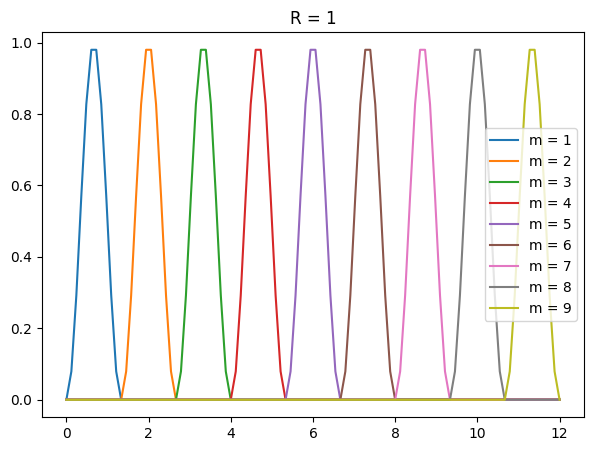

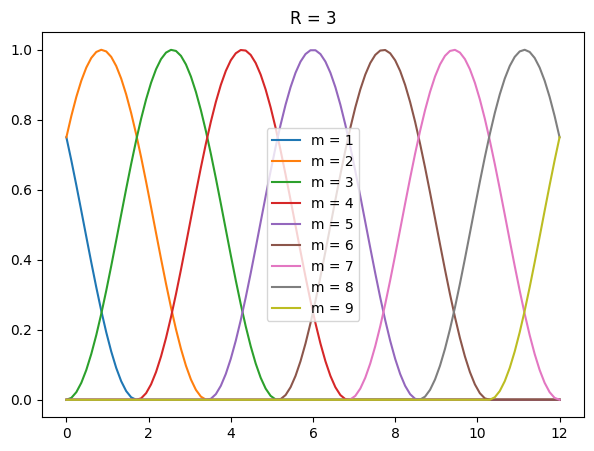

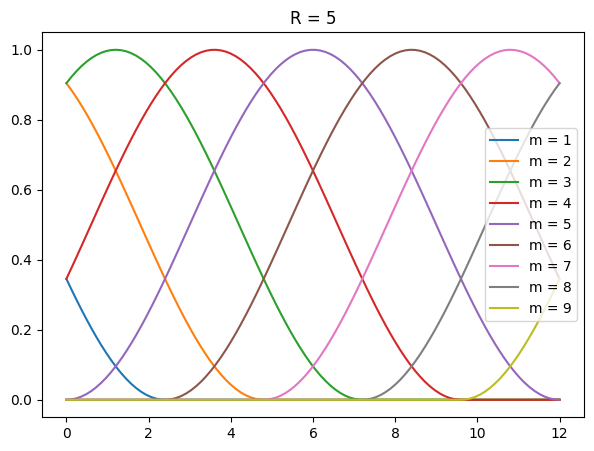

In [67]:
M = 9 
lambda_n = 12
all_R = [1, 3, 5] 
lambda_list = np.linspace(0, lambda_n, 100)

for i in range(len(all_R)):
    plt.figure(figsize=(7, 5))
    for m in range(1, M + 1) :
        all_m = []
        for x in lambda_list : 
            all_m.append(compute_m(x, all_R[i], m))
        plt.plot(lambda_list, all_m, label='m = '+str(m))
    plt.title('R = '+str( all_R[i]))
    plt.legend()
plt.show()

# Question 4

In [68]:
df, stations_df, _ = load_molene_meteo_dataset()
df["celcius"] = df.t - 273.15 
celcius_df = df.pivot(index="date", values="celcius", columns="station_name")
celcius_df.head()

station_name,ARZAL,AURAY,BATZ,BEG_MEIL,BELLE ILE-LE TALUT,BIGNAN,BREST-GUIPAVAS,BRIGNOGAN,CAMARET,DINARD,...,SIBIRIL S A,SIZUN,SPEZET,ST BRIEUC,ST NAZAIRE-MONTOIR,ST-SEGAL S A,THEIX,TREGUNC,VANNES-MEUCON,VANNES-SENE
date,,,,,,,,,,,,,,,,,,,,,
2014-01-01 00:00:00,9.7,10.3,NaN,NaN,11.3,7.1,9.7,NaN,NaN,6.8,...,7.4,8.5,8.3,7.5,9.0,9.0,9.3,10.8,8.5,9.7
2014-01-01 01:00:00,9.8,10.4,NaN,NaN,10.3,7.6,9.6,9.2,NaN,6.5,...,8.2,8.3,8.6,7.0,9.1,9.5,9.1,10.9,8.7,9.9
2014-01-01 02:00:00,9.7,10.0,NaN,NaN,11.2,7.7,9.1,9.4,NaN,6.5,...,8.5,8.5,8.6,7.5,9.5,9.4,9.4,10.6,8.8,9.6
2014-01-01 03:00:00,9.4,10.4,NaN,NaN,11.4,7.9,9.7,10.1,NaN,7.1,...,8.5,8.7,8.9,7.2,9.0,9.9,8.9,10.8,8.6,9.8
2014-01-01 04:00:00,9.8,10.8,NaN,NaN,11.4,8.8,9.8,10.2,NaN,7.6,...,9.1,9.1,9.4,7.6,9.5,10.0,9.6,11.0,9.2,10.2


In [69]:
stations_df.head()

,Numéro,Nom,Latitude,Longitude,X (Lambert II étendu),Y (Lambert II étendu),Altitude
0,22016001,ILE-DE-BREHAT,48.855167,-3.004500,208083,2441852,25
1,22092001,KERPERT,48.404000,-3.147667,194096,2392507,281
2,22113006,LANNAERO,48.755333,-3.468667,173267,2433190,85
3,22135001,LOUARGAT,48.551667,-3.376833,178359,2410097,148
4,22147006,MERDRIGNAC,48.182667,-2.410833,247067,2364385,131


In [70]:
missing_df = pd.DataFrame(celcius_df.isna().sum(axis=0).sort_values(ascending=False), columns=['#missing'])
print('#stations missing values:', missing_df[missing_df['#missing']!=0].index)

#stations missing values: Index(['BATZ', 'BEG_MEIL', 'CAMARET', 'PLOUGONVELIN', 'RIEC SUR BELON',
       'ST NAZAIRE-MONTOIR', 'PLOUAY-SA', 'VANNES-MEUCON', 'LANNAERO',
       'PLOUDALMEZEAU', 'LANDIVISIAU', 'SIZUN', 'QUIMPER', 'OUESSANT-STIFF',
       'LANVEOC', 'ARZAL', 'BREST-GUIPAVAS', 'BRIGNOGAN'],
      dtype='object', name='station_name')


In [71]:
def compute_geodesic_distance(point_1, point_2) -> float:
    longitude_1, latitude_1 = point_1
    longitude_2, latitude_2 = point_2
    longitude_1, latitude_1, longitude_2, latitude_2 = np.radians([longitude_1, latitude_1, longitude_2, latitude_2])
    d_longitude = longitude_2 - longitude_1
    d_latitude = latitude_2 - latitude_1
    a = np.sin(d_latitude / 2) ** 2 + np.cos(latitude_1) * np.cos(latitude_2) * np.sin(d_longitude / 2) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371
    return c * r

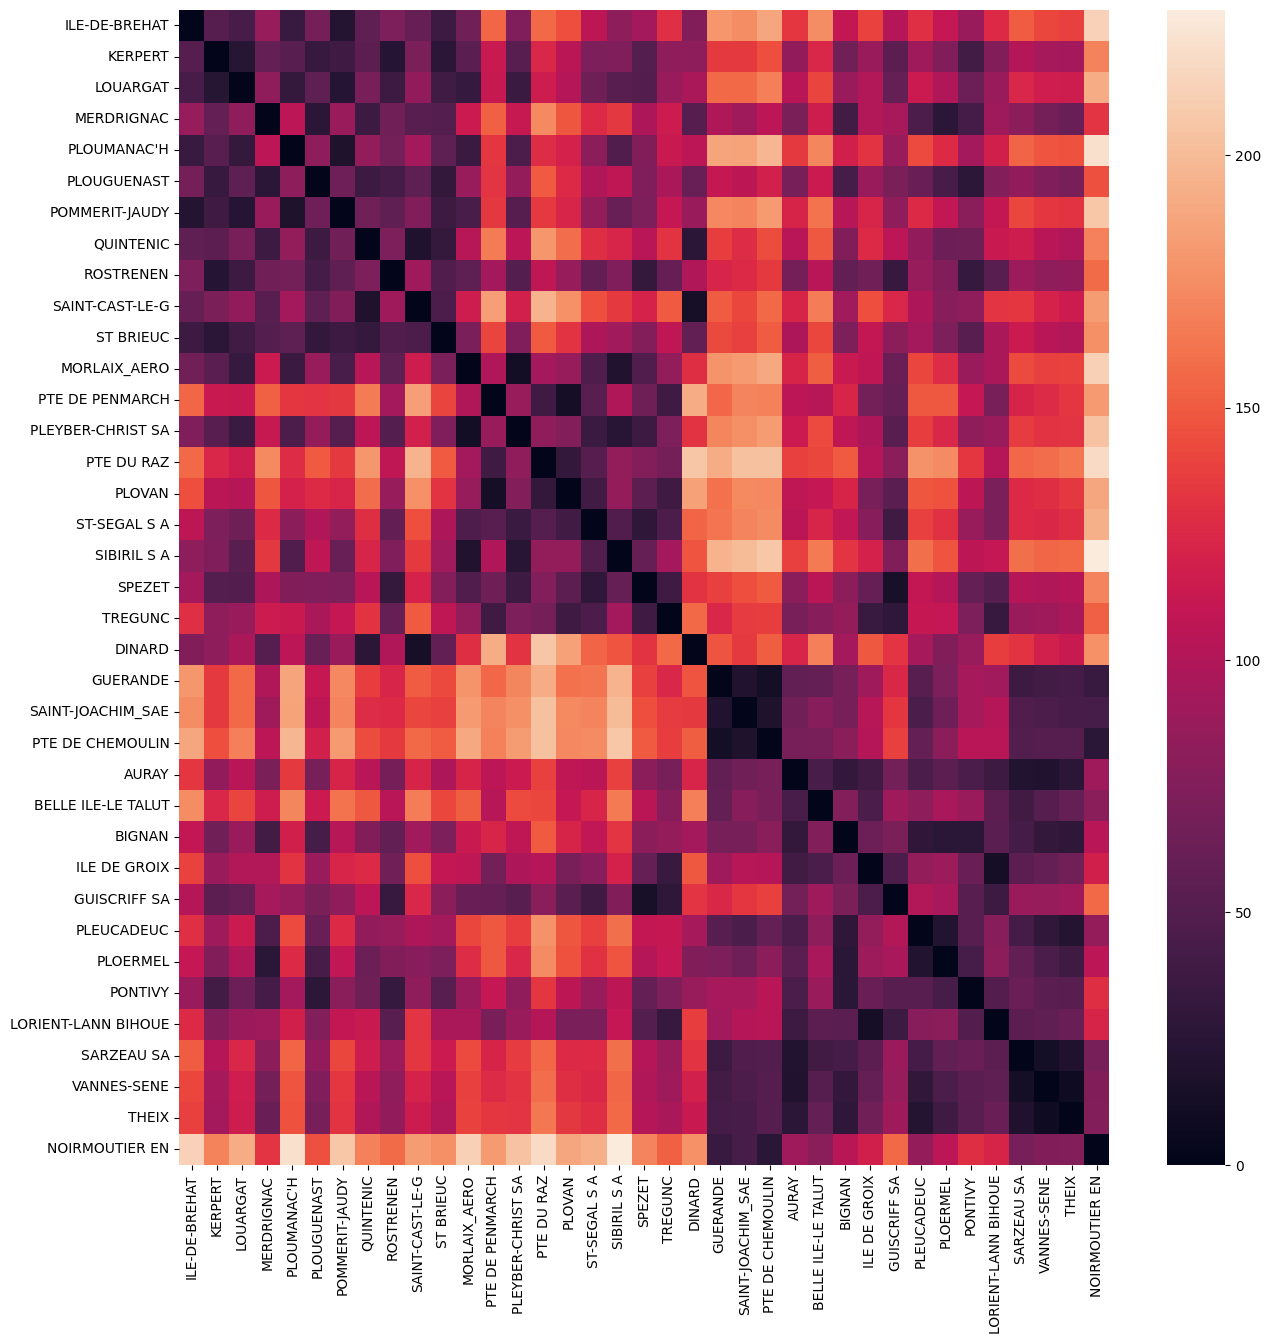

In [72]:
mask = missing_df[missing_df['#missing']==0].index
celcius_df = celcius_df[mask]
stations_df = stations_df[stations_df['Nom'].isin(mask)]
stations_gdf = geopandas.GeoDataFrame(
    stations_df,
    geometry=geopandas.points_from_xy(stations_df.Longitude, stations_df.Latitude),
).set_crs("EPSG:4326")

stations_array = stations_df[["Longitude", "Latitude"]].to_numpy()
pdist_matrix = pdist(stations_array, metric=compute_geodesic_distance)
square_dist_matrix = squareform(pdist_matrix)

plt.figure(figsize=(15, 15))
sns.heatmap(square_dist_matrix, xticklabels=stations_df.Nom, yticklabels=stations_df.Nom)
plt.show()

In [73]:
def compute_exp_sim(matrix, bandwidth, threshold):
    exp_sim = np.exp(-(matrix ** 2) / bandwidth**2)
    res_arr = np.where(exp_sim > threshold, exp_sim, 0.0)
    return res_arr

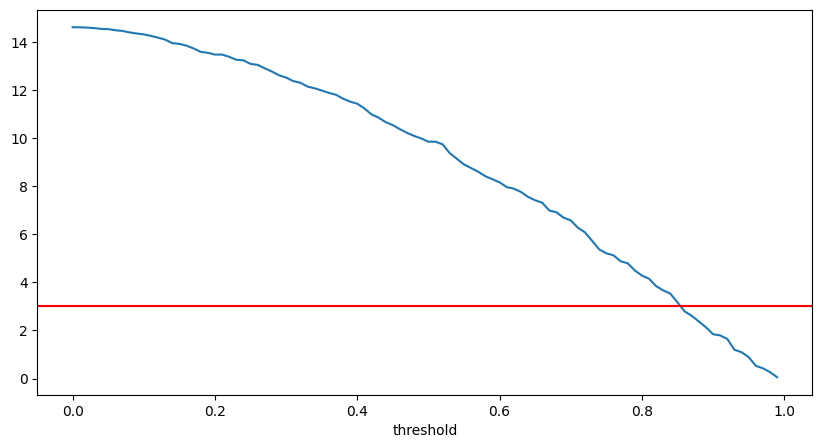

Average degree = 3.66. Threshold of 0.83


In [74]:
sigma = np.median(pdist_matrix) 
thresholds = np.arange(0, 1, 0.01)

degrees = []
for threshold in thresholds : 
	adj_matrix = squareform(compute_exp_sim(pdist_matrix, sigma, threshold))
	degrees.append(np.mean(adj_matrix.sum(axis=1)))

plt.figure(figsize=(10,5))
plt.plot(thresholds,degrees)
plt.axhline(y=3, color='red')
plt.xlabel('threshold')
plt.show()

for threshold in thresholds[::-1] :
	adj_matrix = squareform(compute_exp_sim(pdist_matrix, sigma, threshold))
	G = graphs.Graph(adj_matrix)
	degree = np.mean(adj_matrix.sum(axis=1))
	if G.is_connected(recompute=True) and degree >= 3 :
		print(f"Average degree = {degree:.2f}. Threshold of {threshold:.2f}")
		break

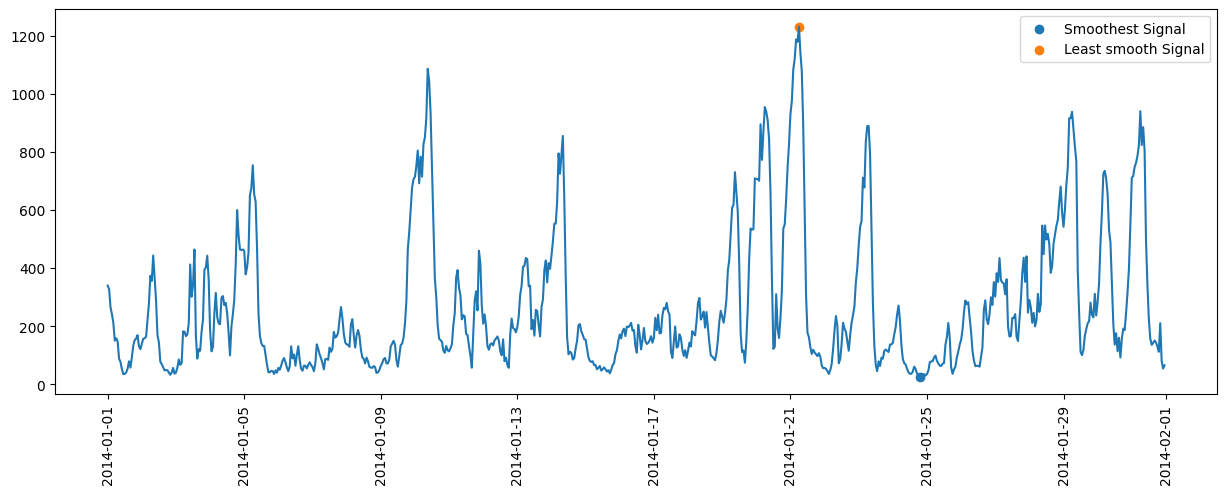

smoothest signal time: 2014-01-24 19:00:00
least smooth time: 2014-01-21 06:00:00


In [75]:
laplacian = G.L.todense()

smoothness = []
for date in celcius_df.index:
    signal = celcius_df.loc[date].to_numpy()
    smoothness.append(float(signal.T.dot(laplacian).dot(signal)))

plt.figure(figsize=(15,5))
plt.plot(celcius_df.index, smoothness)
plt.scatter(celcius_df.index[np.argmin(smoothness)], np.min(smoothness), label = 'Smoothest Signal')
plt.scatter(celcius_df.index[np.argmax(smoothness)], np.max(smoothness), label = 'Least smooth Signal')
plt.legend()
plt.xticks(rotation=90)
plt.show()


print(f"smoothest signal time: {celcius_df.index[np.argmin(smoothness)]}")
print(f"least smooth time: {celcius_df.index[np.argmax(smoothness)]}")

# Question 5

In [76]:
def question5(index):
	f = celcius_df.loc[celcius_df.index[index]].to_numpy()
	adj_matrix = squareform(compute_exp_sim(pdist_matrix, sigma, 0.83))
	G = graphs.Graph(adj_matrix)
	laplacian = G.L.todense()
	eig_values, eig_vectors = eig(laplacian)
	eig_values = np.real(eig_values)
	argsort = eig_values.argsort()
	eig_values = eig_values[argsort]
	eig_vectors = eig_vectors[:, argsort]
	f = eig_vectors.T.dot(f)

	M = 9
	R = 3
	labels = []
	for v in range(len(f)):
		W_v = []
		for m in range(1, M+1):
			W = 0
			for i in range(len(eig_values)):
				W += compute_m(eig_values[i], R, m, lambda_n=eig_values[-1]) * f[i] * eig_vectors[v, i]
			W_v.append(W)
		labels.append(np.argmax(
			[(np.abs(W_v[:3]) ** 2).sum(), (np.abs(W_v[3:6]) ** 2).sum(), (np.abs(W_v[6:]) ** 2).sum()])
		)

	ax = stations_gdf.geometry.plot(figsize=(10, 5))
	cx.add_basemap(ax, crs=stations_gdf.crs.to_string(), zoom=8)
	ax.set_axis_off()
	G.set_coordinates(stations_array)
	G.plot_signal(np.array(labels), ax=ax)
	ax.set_title(f"{celcius_df.index[index]}")


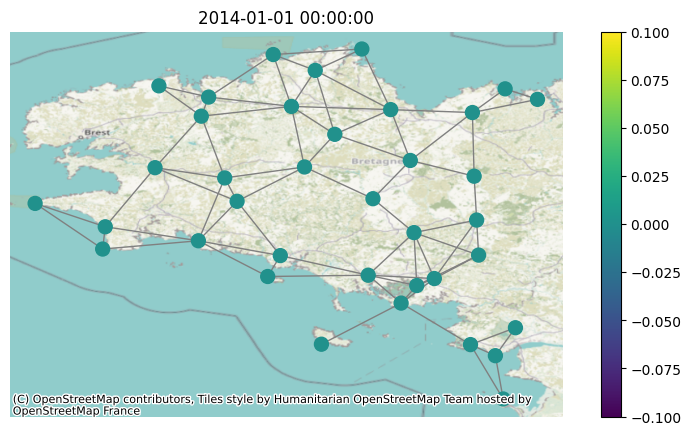

In [77]:
question5(0)

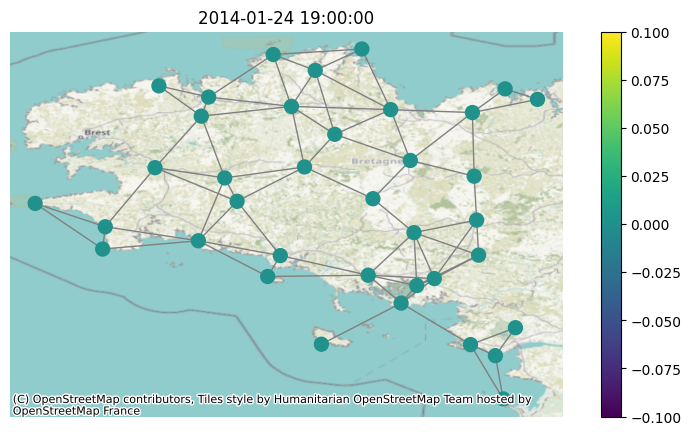

In [78]:
question5(np.argmin(smoothness))

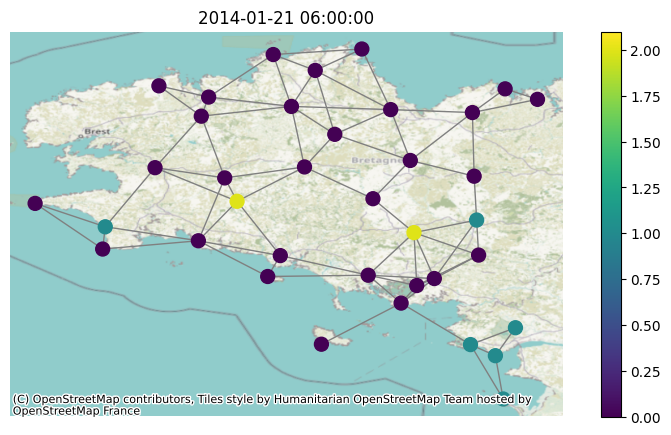

In [79]:
question5(np.argmax(smoothness))

# Question 6

In [80]:
classes = []
for index in range(len(celcius_df.index)):
    f = celcius_df.loc[celcius_df.index[index]].to_numpy()
    adj_matrix = squareform(compute_exp_sim(pdist_matrix, sigma, 0.83))
    G = graphs.Graph(adj_matrix)
    laplacian = G.L.todense()
    eig_values, eig_vectors = eig(laplacian)
    eig_values = np.real(eig_values)
    argsort = eig_values.argsort()
    eig_values = eig_values[argsort]
    eig_vectors = eig_vectors[:, argsort]
    f = eig_vectors.T.dot(f)
    M = 9
    R = 3
    labels = []
    for v in range(len(f)):
        W_v = []
        for m in range(1, M + 1):
            W = 0
            for i in range(len(eig_values)):
                W += compute_m(eig_values[i], R, m, lambda_n=eig_values[-1]) * f[i] * eig_vectors[v, i]
            W_v.append(W)
        labels.append(np.argmax(
			[(np.abs(W_v[:3]) ** 2).sum(), (np.abs(W_v[3:6]) ** 2).sum(), (np.abs(W_v[6:]) ** 2).sum()])
		)
    classes.append(Counter(labels).most_common()[0][0])

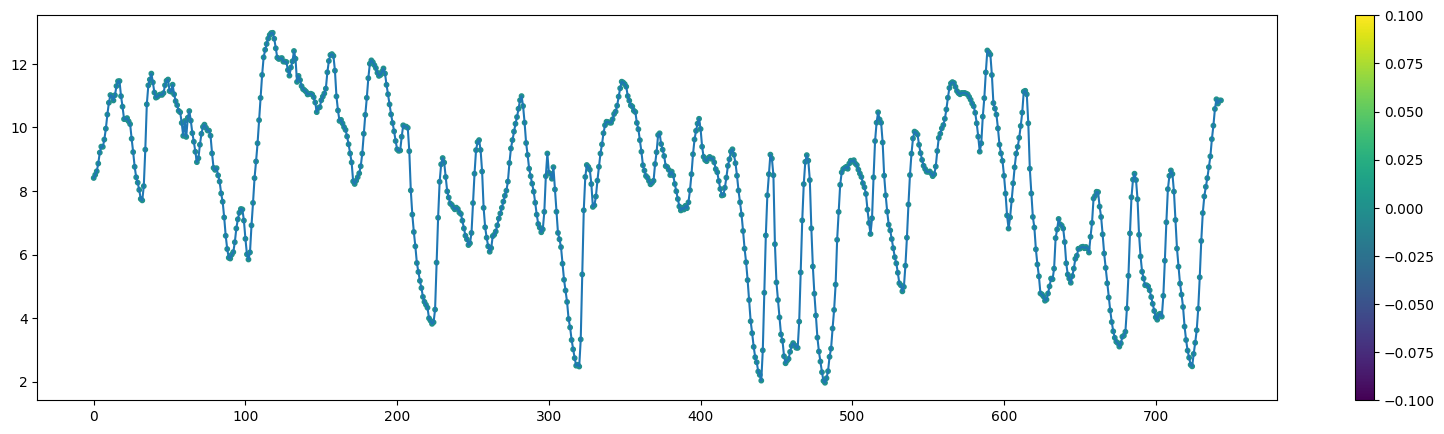

In [81]:
mean_df = celcius_df.mean(axis=1)
plt.figure(figsize=(20, 5))
plt.scatter(np.arange(mean_df.shape[0]), mean_df, c=classes, marker='o', s=10)
plt.plot(np.arange(mean_df.shape[0]), mean_df)
plt.colorbar()
plt.show()

# Question 7

In [ ]:
n = celcius_df.index.size
adj_matrix = np.identity(n)
adj_matrix = np.c_[adj_matrix[:, -1], adj_matrix[:, :-1]]
adj_matrix += adj_matrix.T
G = graphs.Graph(adj_matrix)
G.set_coordinates(kind="ring2D")
G.compute_laplacian("combinatorial")
t_laplacian = G.L.todense()

adj_matrix = squareform(compute_exp_sim(pdist_matrix, sigma, 0.83))
G = graphs.Graph(adj_matrix)
s_laplacian = G.L.todense()

t_eig_values, t_eig_vectors = eig(t_laplacian)
s_eig_values, s_eig_vectors = eig(s_laplacian)
t_eig_values = np.real(t_eig_values)
s_eig_values = np.real(s_eig_values)

size = t_laplacian.shape[0] * s_laplacian.shape[0]
eig_values = np.zeros(size)
eig_vectors = np.zeros((size, size))
for i in range(t_eig_values.shape[0]):
    for j in range(s_eig_values.shape[0]):
        eig_values[s_eig_values.shape[0] * i + j] = t_eig_values[i] + s_eig_values[j]
        eig_vectors[:, s_eig_values.shape[0] * i + j] = np.kron(t_eig_vectors[:, i], s_eig_vectors[:, j])

f = np.ravel(celcius_df.to_numpy(), order='F')
argsort = eig_values.argsort()
eig_values = eig_values[argsort]
eig_vectors = eig_vectors[:, argsort]
f = eig_vectors.T @ f 
M = 9
R = 3
labels = []
for v in range(len(f)):
    W_v = []
    for m in range(1, M + 1):
        W = 0
        for i in range(len(eig_values)):
            W += compute_m(eig_values[i], R, m, lambda_n=eig_values[-1]) * f[i] * eig_vectors[v, i]
        W_v.append(W)
    labels.append(np.argmax(
		[(np.abs(W_v[:3]) ** 2).sum(), (np.abs(W_v[3:6]) ** 2).sum(), (np.abs(W_v[6:]) ** 2).sum()])
	)

labels = np.array(labels).reshape(celcius_df.shape)
classes = []
for i in range(labels.shape[0]):
    unique, counts = np.unique(labels[i], return_counts=True)
    classes.append(unique[np.argmax(counts)])

In [ ]:
mean_df = celcius_df.mean(axis=1)
plt.figure(figsize=(20, 5))
plt.scatter(np.arange(mean_df.shape[0]), mean_df, c=classes, marker='o', s=10)
plt.plot(np.arange(mean_df.shape[0]), mean_df)
plt.colorbar()
plt.show()